# Apple hisse verilerini kullanarak LSTM modelinin eğitimi ve ileriye dönük tahminlemeleri için bir çalışma



# Kullanacağımız Kütüphaneleri ekliyoruz

In [ ]:

import warnings
import itertools

from math import sqrt
from datetime import datetime
from numpy import concatenate
import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, Bidirectional, GRU
from sklearn.utils import shuffle


import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('fivethirtyeight')


# Hisse fiyatlarını Yahoo borsa web sitesinden çekiyoruz
link : https://finance.yahoo.com/quote/AAPL/history?period1=1325376000&period2=1672444800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [ ]:
df = pd.read_csv('/content/AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,14.62,14.73,14.61,14.69,12.48,302220800
1,2012-01-04,14.64,14.81,14.62,14.77,12.55,260022000
2,2012-01-05,14.82,14.95,14.74,14.93,12.69,271269600
3,2012-01-06,14.99,15.10,14.97,15.09,12.82,318292800
4,2012-01-09,15.20,15.28,15.05,15.06,12.80,394024400


# Verimizin şekline bakalım

In [ ]:
df.shape


(2768, 7)

In [ ]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2763,2022-12-23,130.92,132.42,129.64,131.86,131.48,63814900
2764,2022-12-27,131.38,131.41,128.72,130.03,129.65,69007800
2765,2022-12-28,129.67,131.03,125.87,126.04,125.67,85438400
2766,2022-12-29,127.99,130.48,127.73,129.61,129.23,75703700
2767,2022-12-30,128.41,129.95,127.43,129.93,129.55,77034200


# En üst kolonda bulunan rakamlarin yerine Tarih kapanış gibi kolon isimlerini koymak için ilk satırı silelim

In [ ]:
# df.columns = df.iloc[0]
# df = df[1:]

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,14.62,14.73,14.61,14.69,12.48,302220800
1,2012-01-04,14.64,14.81,14.62,14.77,12.55,260022000
2,2012-01-05,14.82,14.95,14.74,14.93,12.69,271269600
3,2012-01-06,14.99,15.10,14.97,15.09,12.82,318292800
4,2012-01-09,15.20,15.28,15.05,15.06,12.80,394024400


# Verimizi çizdirelim

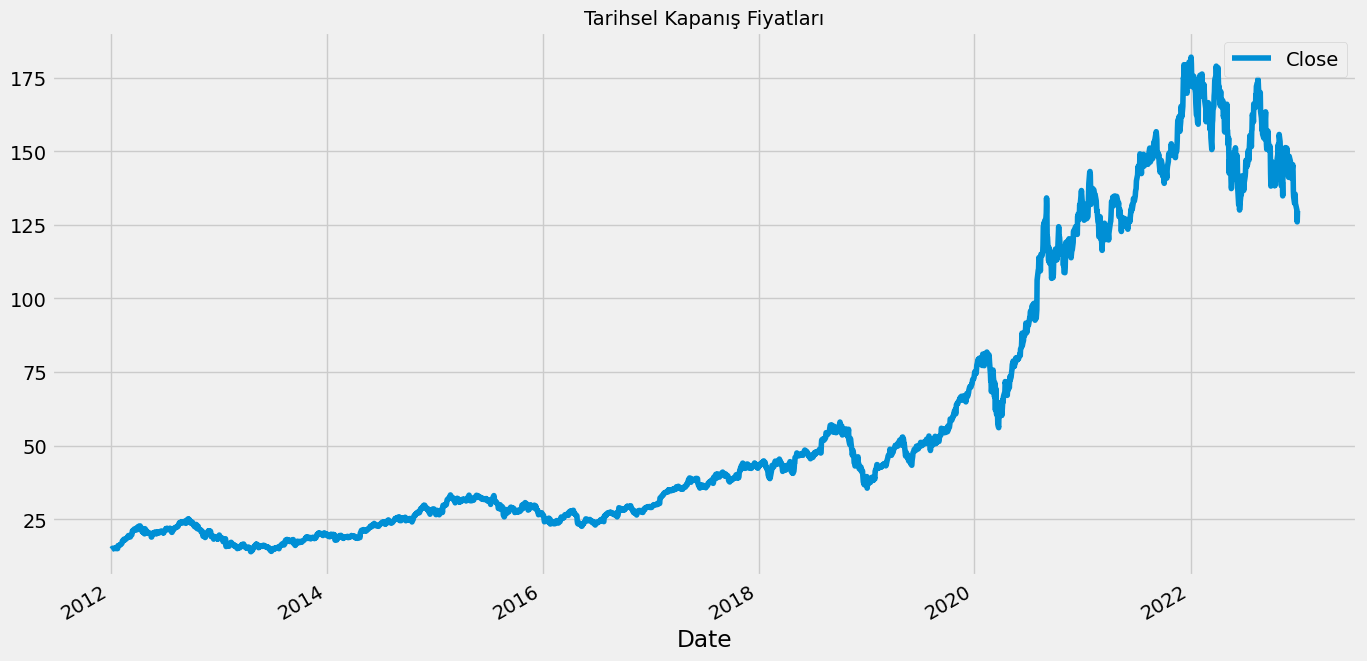

In [ ]:
df['Close'] = df['Close'].astype(float)
df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)
fig = plt.figure(figsize=(15, 8))
df['Close'].plot(label='Close')
plt.legend(loc='best')
plt.title('Tarihsel Kapanış Fiyatları', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')
plt.show()


# Model için kullanacağımız veri kolonunu numpy arraye çevirip farklı bir değişkende tutalım

In [ ]:
data = df.filter(['Close'])

dataset = data.values

training_data_len = math.ceil ( len (dataset) * 8)

training_data_len

22144

# Veriyi uygun formata getirip hazırlayalım

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00439888],
       [0.00486851],
       [0.00584392],
       ...,
       [0.66696916],
       [0.68821126],
       [0.69011526]])

# Eğitim ve Test veri setini  hazırlayalım , Eğitim veri seti modeli besleyecek , Test veri seti ile ise modelin başarısını ölçeceğiz. Burada % 80 eğitim için % 20 ise Test için ayırıyoruz

In [ ]:
# Veri setini oluşturma
def create_data(data, n_lookback=1):
    x, y = [], []
    for i in range(len(data)-n_lookback):
        x.append(data[i:(i+n_lookback)])
        y.append(data[i+n_lookback])
    return np.array(x), np.array(y)

# Elde ettiğimiz x_train , y_train yapılarını Modele uygun veri tipi olan numpy array e çevirelim


In [ ]:
n_lookback = 1  # Örnek olarak n_lookback değerini 60 olarak ayarlıyoruz
x, y = create_data(scaled_data, n_lookback)

# Eğitim ve test veri setlerini ayırma
train_size = int(len(x) * 0.8)
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

# Veriyimizn şekli şuanda iki boyutlu fakat LSTM modeli 3 boyulu veri yapısı ile çalışıyor . O Halde verimizi 3 boyulu hale getirelim

In [ ]:
# x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1))

# x_train.shape

# LSTM modelimizi yaratalım katmanlarını ve yapısını oluşturalım

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# Modelimizi ayırdığımız eğitim veri seti ile eğitelim  , batch_size verileri nasıl bir paket halinde vereceğimizi belirtirken epochs ise ver seti üzerinde kaç kere gezeceğini belirtir.


In [ ]:
model.fit(x_train,y_train , batch_size=32 , epochs=25)

Epoch 1/25
70/70 [==============================] - 1s 15ms/step - loss: 7.5857e-05
Epoch 2/25
70/70 [==============================] - 1s 11ms/step - loss: 5.6957e-05
Epoch 3/25
70/70 [==============================] - 1s 10ms/step - loss: 4.8218e-05
Epoch 4/25
70/70 [==============================] - 1s 11ms/step - loss: 4.0968e-05
Epoch 5/25
70/70 [==============================] - 1s 12ms/step - loss: 3.7970e-05
Epoch 6/25
70/70 [==============================] - 1s 12ms/step - loss: 3.8434e-05
Epoch 7/25
70/70 [==============================] - 1s 8ms/step - loss: 3.5241e-05
Epoch 8/25
70/70 [==============================] - 1s 8ms/step - loss: 3.4834e-05
Epoch 9/25
70/70 [==============================] - 1s 8ms/step - loss: 3.4690e-05
Epoch 10/25
70/70 [==============================] - 1s 8ms/step - loss: 3.6123e-05
Epoch 11/25
70/70 [==============================] - 1s 8ms/step - loss: 3.5297e-05
Epoch 12/25
70/70 [==============================] - 1s 8ms/step - loss: 3.6152

In [ ]:
test_predict = model.predict(x_test)
test_predict = scaler.inverse_transform(test_predict)

18/18 [==============================] - 2s 5ms/step


In [ ]:
temp = x_test

In [ ]:
df_predicted = pd.DataFrame({'tarih': df.index[train_size+1:train_size+1+len(x_test)], 'predicted_close': test_predict.flatten()})

# Tahminlenmiş verileri gösterme
print(df_predicted)


         tarih  predicted_close
0   2020-10-20           116.89
1   2020-10-21           118.39
2   2020-10-22           117.76
3   2020-10-23           116.66
4   2020-10-26           115.96
..         ...              ...
549 2022-12-23           132.70
550 2022-12-27           132.35
551 2022-12-28           130.58
552 2022-12-29           126.72
553 2022-12-30           130.18

[554 rows x 2 columns]


In [ ]:
df_predicted.set_index('tarih', inplace=True)
df_predicted["predicted_close"].tail(60)

tarih
2022-10-06   146.17
2022-10-07   145.26
2022-10-10   140.21
2022-10-11   140.53
2022-10-12   139.16
2022-10-13   138.55
2022-10-14   142.96
2022-10-17   138.59
2022-10-18   142.41
2022-10-19   143.68
2022-10-20   143.78
2022-10-21   143.34
2022-10-24   146.99
2022-10-25   149.03
2022-10-26   151.72
2022-10-27   148.94
2022-10-28   144.67
2022-10-31   154.87
2022-11-01   152.65
2022-11-02   150.15
2022-11-03   144.89
2022-11-04   139.06
2022-11-07   138.59
2022-11-08   139.10
2022-11-09   139.65
2022-11-10   135.24
2022-11-11   146.61
2022-11-14   149.26
2022-11-15   147.94
2022-11-16   149.58
2022-11-17   148.41
2022-11-18   150.21
2022-11-21   150.74
2022-11-22   147.68
2022-11-23   149.71
2022-11-25   150.54
2022-11-28   147.78
2022-11-29   144.12
2022-11-30   141.24
2022-12-01   147.70
2022-12-02   147.96
2022-12-05   147.50
2022-12-06   146.39
2022-12-07   142.89
2022-12-08   141.02
2022-12-09   142.64
2022-12-12   142.18
2022-12-13   144.38
2022-12-14   145.30
2022-12-15   1

<Figure size 1500x800 with 0 Axes>

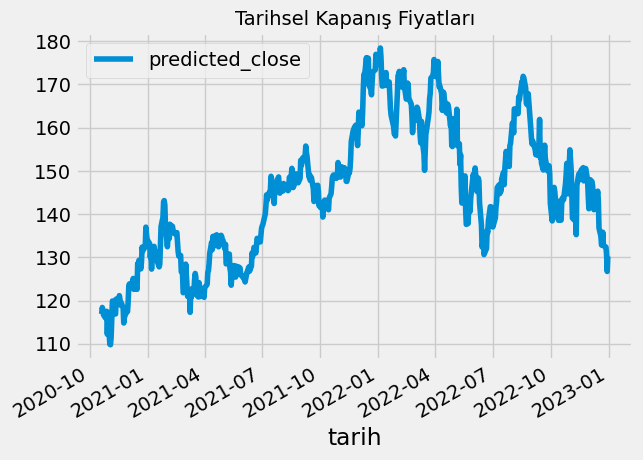

In [ ]:
fig = plt.figure(figsize=(15,8))
df_predicted.plot(label='predicted_close')
plt.legend(loc='best')
plt.title('Tarihsel Kapanış Fiyatları', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

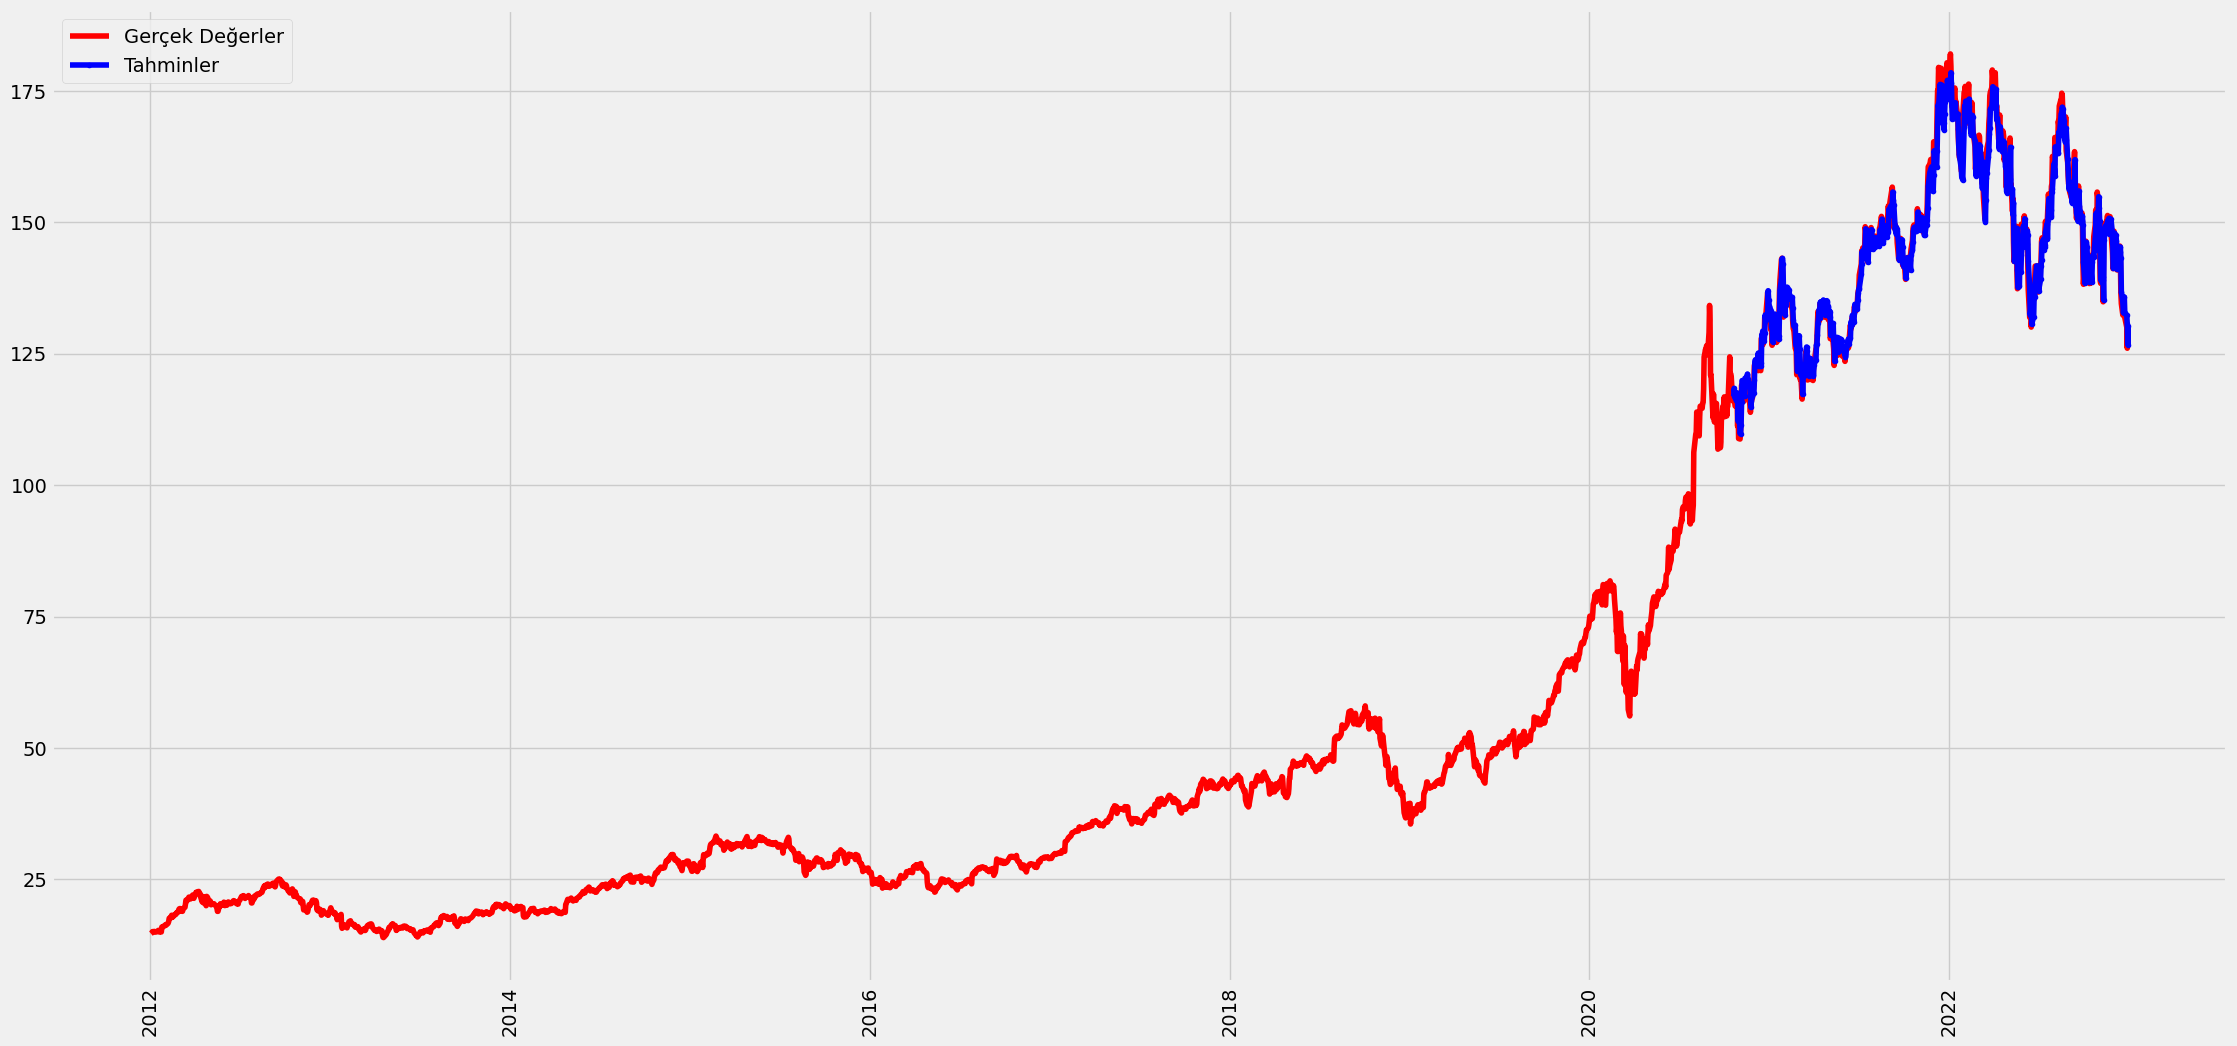

In [ ]:
# df_predicted DataFrame'inin boyutunu data DataFrame'i ile uyumlu hale getirme
df_predicted_resized = df_predicted.iloc[:len(df)]

# Grafik oluşturma
plt.figure(figsize=(25, 12))

ax1 = plt.subplot()
l1, = ax1.plot(df.index[:-1], df["Close"][:-1], color='red')
plt.ticklabel_format(axis='y')

ax2 = plt.subplot()
l2, = ax2.plot(df_predicted_resized.index, df_predicted_resized["predicted_close"], color='blue', marker='.')

plt.legend([l1, l2], ["Gerçek Değerler", "Tahminler"])
plt.xticks(rotation=90)
plt.grid(True)
plt.ticklabel_format(style='plain', axis="y")
plt.show()

In [ ]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

# Gerçek değerlerin ve tahminlerin NRMSE hesaplaması
test_nrmse = (test_rmse / (max(data["Close"])-min(data["Close"])))*100

print("Test verisi RMSE:", test_rmse)
print("Test verisi NRMSE:", test_nrmse)

Test verisi RMSE: 145.05611168846093
Test verisi NRMSE: 86.3108165140955


In [ ]:
def calc_mse(y_true,y_pred):
  mse = np.mean((y_true-y_pred)**2)
  var = np.var(y_true)
  return (mse/var)

calc_mse(y_test,test_predict)

2103026.4012779444

In [ ]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [ ]:
# Tahmin fonksiyonu
def predict_future(model, data, n_future):
    last_data = data[-n_lookback:]  # Son n_lookback veriyi alıyoruz
    predictions = []  # Tahminleri tutacak bir liste oluşturuyoruz

    for _ in range(n_future):
        # Son verileri modele verip bir sonraki günü tahmin ediyoruz
        prediction = model.predict(last_data.reshape(1, n_lookback, 1))
        predictions.append(prediction[0, 0])
        last_data = np.concatenate((last_data[1:], prediction), axis=0)

    # Tahmin sonuçlarını ters ölçeklendirme
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    return predictions

In [ ]:
# 2023 yılının tahminini yapma
n_future = 90  # Örnek olarak sonraki 90 günü tahmin ediyoruz
predictions = predict_future(model, scaled_data, n_future)

1/1 [==============================] - 0s 27ms/step


In [ ]:
# Tahmin sonuçlarını tarihlerle birlikte DataFrame olarak oluşturma
start_date = pd.to_datetime('2023-01-01')
date_range = pd.date_range(start=start_date, periods=n_future, freq='D')
predictions_df = pd.DataFrame(predictions, index=date_range, columns=['Tahmin'])

In [ ]:
predictions_df

,Tahmin
2023-01-01,130.49
2023-01-02,131.02
2023-01-03,131.54
2023-01-04,132.04
2023-01-05,132.52
...,...
2023-03-27,142.35
2023-03-28,142.35
2023-03-29,142.36
2023-03-30,142.37


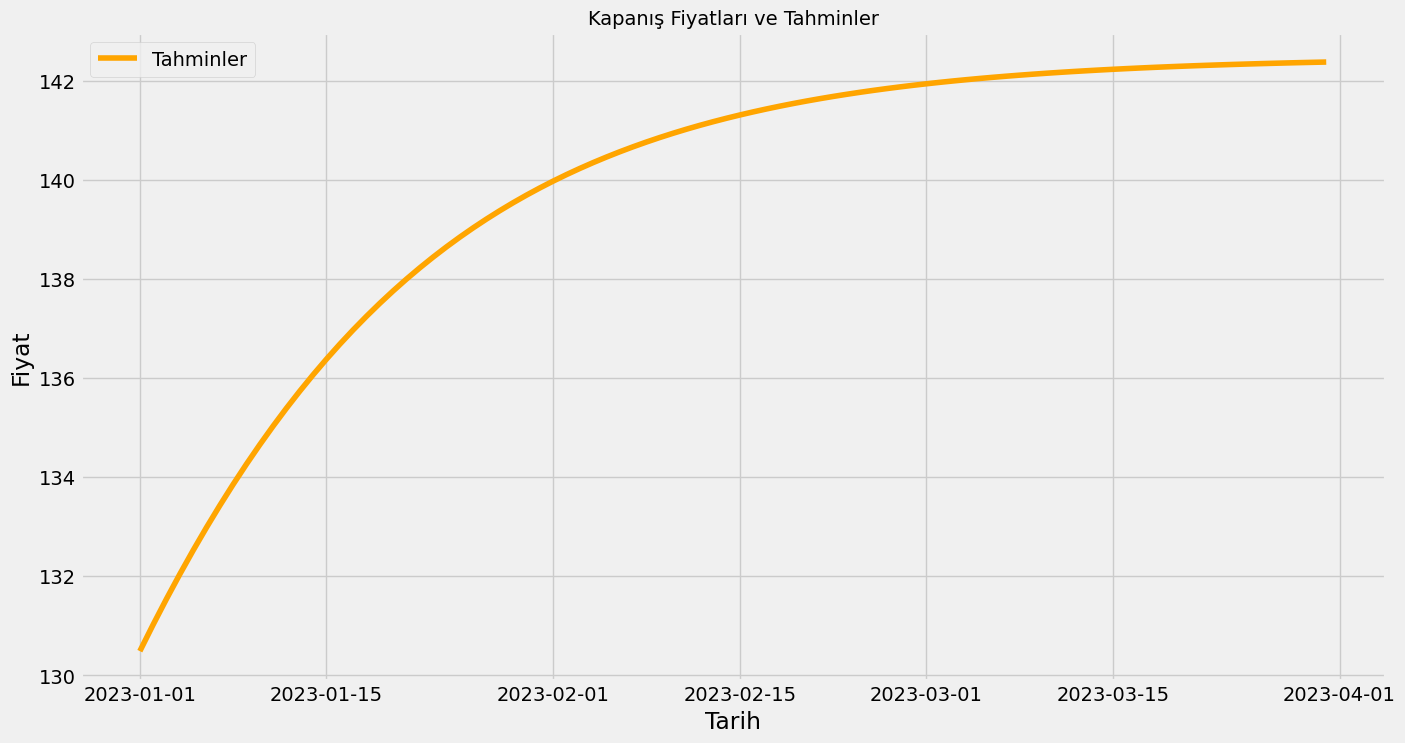

In [ ]:
fig = plt.figure(figsize=(15, 8))

# # Gerçek veriler
# plt.plot(df.index[:-n_future], df["Close"][:-n_future], color='red', label='Gerçek Veriler')

# # Eğitim verileri
# plt.plot(df.index[:train_size], df["Close"][:train_size], color='blue', label='Eğitim Verileri')

# # Test verileri
# plt.plot(df.index[train_size:], df["Close"][train_size:], color='green', label='Test Verileri')

# Tahminler
plt.plot(predictions_df.index, predictions_df["Tahmin"], color='orange', label='Tahminler')

plt.legend(loc='best')
plt.title('Kapanış Fiyatları ve Tahminler', fontsize=14)
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


In [ ]:
trace1 = go.Scatter(
    x = df.index,
    y = df['Close'],
    mode = 'lines',
    name = 'Train Data'
)
trace2 = go.Scatter(
    x = df_predicted_resized.index,
    y = df_predicted_resized["predicted_close"],
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = predictions_df.index,
    y = predictions_df["Tahmin"],
    mode = 'lines',
    name = 'test'
)
layout = go.Layout(
    title = "Apple Hisse Senedi Tahmini",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Balance"}
)
fig = go.Figure(data=[trace1, trace2,trace3], layout=layout)
fig.show()

In [ ]:
tracex = go.Scatter(
    x = predictions_df.index,
    y = predictions_df["Tahmin"],
    mode = 'lines',
    name = 'Prediction'
)
layoutt = go.Layout(
    title = "xxxxx",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Balance"}
)
fig = go.Figure(data=[tracex], layout=layoutt)
fig.show()